In [10]:
import sys

import numpy as np

sys.path.append("../../")

from hyperparameter_optimization.hyperopt import save_search_space


import dill as pickle
from hyperopt import hp
from hyperopt.pyll import scope
from utils import CategoricalCrossentropyLoss, MSELoss, generate_layer_widths
import gymnasium as gym
import torch
from muzero.action_functions import action_as_plane as action_function
from torch.optim import Adam, SGD

search_space = {
    "kernel_initializer": hp.choice(
        "kernel_initializer",
        [
            "he_uniform",
            "he_normal",
            "glorot_uniform",
            "glorot_normal",
            "orthogonal",
        ],
    ),
    "optimizer": hp.choice(
        "optimizer",
        [
            {
                "optimizer": "adam",
                # "adam_epsilon": hp.qloguniform(
                #     "adam_epsilon", np.log(1e-8), np.log(0.5), 1e-8
                # ),
                "adam_epsilon": 10 ** (-hp.quniform("adam_epsilon", 1, 8, 1)),
            },
            {
                "optimizer": "sgd",
                "momentum": hp.quniform("momentum", 0, 1, 0.1),
            },
        ],
    ),
    "conv_layers": hp.choice("conv_layers", [[]]),
    # "learning_rate": hp.qloguniform(
    #     "learning_rate", np.log(0.0001), np.log(0.01), 0.0001
    # ),
    "learning_rate": 10 ** (-hp.quniform("learning_rate", 2, 4, 1)),
    "known_bounds": hp.choice("known_bounds", [[-1, 1]]),
    "residual_filters": scope.int(
        hp.qloguniform("residual_filters", np.log(8), np.log(32), 8)
    ),
    "residual_stacks": scope.int(
        hp.qloguniform("residual_stacks", np.log(1), np.log(5), 1)
    ),
    "conv_layers": hp.choice("conv_layers", [[]]),
    "dense_layers": hp.choice("dense_layers", [[]]),
    "actor_and_critic_conv_filters": scope.int(
        hp.qloguniform(
            "actor_and_critic_conv_filters", np.log(0 + 8), np.log(32 + 8), 8
        )
        - 8  # to make 0 an option
    ),
    "reward_conv_layers": hp.choice("reward_conv_layers", [[]]),
    "actor_dense_layer_widths": hp.choice("actor_dense_layer_widths", [[]]),
    "critic_dense_layer_widths": hp.choice("critic_dense_layer_widths", [[]]),
    "reward_dense_layer_widths": hp.choice("reward_dense_layer_widths", [[]]),
    "dense_layer_widths": hp.choice("dense_layer_widths", [[]]),
    "noisy_sigma": hp.choice("noisy_sigma", [0.0]),
    "value_loss_factor": hp.choice("value_loss_factor", [1.0]),
    "root_dirichlet_alpha": hp.quniform(
        "root_dirichlet_alpha", 0.1, 2.0, 0.1
    ),  # hp.choice("root_dirichlet_alpha", [0.3, 1.0, 2.0]),
    "root_exploration_fraction": hp.choice("root_exploration_fraction", [0.25]),
    "num_simulations": scope.int(
        hp.qloguniform("num_simulations", np.log(25), np.log(25) + 1e-10, 25)
    ),
    "num_sampling_moves": scope.int(hp.quniform("num_sampling_moves", 0, 8, 1)),
    "exploration_temperature": hp.choice("exploration_temperature", [1.0]),
    "exploitation_temperature": hp.choice("exploitation_temperature", [0.1]),
    "clip_low_prob": hp.choice("clip_low_prob", [0.0]),
    "pb_c_base": hp.choice("pb_c_base", [19652]),
    "pb_c_init": hp.choice("pb_c_init", [1.25]),
    "value_loss_function": hp.choice("value_loss_function", [MSELoss()]),
    "reward_loss_function": hp.choice("reward_loss_function", [MSELoss()]),
    "policy_loss_function": hp.choice(
        "policy_loss_function", [CategoricalCrossentropyLoss()]
    ),
    "training_steps": scope.int(
        hp.qloguniform("training_steps", np.log(10000), np.log(30000), 10000)
    ),
    # "minibatch_size": scope.int(
    #     hp.qloguniform("minibatch_size", np.log(8), np.log(64), 8)
    # ),
    # "min_replay_buffer_size": scope.int(
    #     hp.qloguniform("min_replay_buffer_size", np.log(1000), np.log(10000), 1000)
    # ),
    # "replay_buffer_size": scope.int(
    #     hp.qloguniform("replay_buffer_size", np.log(10000), np.log(200000), 10000)
    # ),
    "minibatch_size": scope.int(2 ** (hp.quniform("minibatch_size", 3, 6, 1))),
    "min_replay_buffer_size": scope.int(
        hp.qloguniform("min_replay_buffer_size", np.log(1000), np.log(10000), 1000)
    ),
    "replay_buffer_size": scope.int(10 ** (hp.quniform("replay_buffer_size", 4, 6, 1))),
    "unroll_steps": hp.choice("unroll_steps", [5]),
    "n_step": hp.choice("n_step", [9]),
    "clipnorm": scope.int(hp.quniform("clipnorm", 0, 10.0, 1)),
    "weight_decay": hp.choice("weight_decay", [1e-4]),
    "per_alpha": hp.choice("per_alpha", [0.0]),
    "per_beta": hp.choice("per_beta", [0.0]),
    "per_beta_final": hp.choice("per_beta_final", [0.0]),
    "per_epsilon": hp.choice("per_epsilon", [1e-4]),
    "action_function": hp.choice("action_function", [action_function]),
    "multi_process": hp.choice(
        "multi_process",
        [
            {
                "multi_process": True,
                "num_workers": scope.int(hp.quniform("num_workers", 1, 3, 1)),
            },
            # {
            #     "multi_process": False,
            #     "games_per_generation": scope.int(
            #         hp.qloguniform("games_per_generation", np.log(8), np.log(32), 8)
            #     ),
            # },
        ],
    ),
    "lr_ratio": hp.pchoice("lr_ratio", [(0.9, float("inf")), (0.1, 0.1)]),
}

initial_best_config = []

search_space, initial_best_config = save_search_space(search_space, initial_best_config)

In [2]:
import pandas as pd
import random
from tqdm import tqdm
import sys
import dill as pickle

sys.path.append("../../")
from elo.elo import StandingsTable

games_per_pair = 10
try:
    table = pickle.load(open("hyperopt_elo_table.pkl", "rb"))
except:
    table = StandingsTable([], start_elo=1000)

print(table.bayes_elo())
print(table.get_win_table())
print(table.get_draw_table())

{'Elo table': Empty DataFrame
Columns: [Elo, Games, Score, Draws]
Index: [], 'eloAdvantage': 0.0, 'eloDraw': 1000.0}
[]
[]


In [6]:
from game_configs.tictactoe_config import TicTacToeConfig
import torch

from pettingzoo.classic import tictactoe_v3


def play_game(player1, player2):

    env = TicTacToeConfig().make_env()
    with torch.no_grad():  # No gradient computation during testing
        # Reset environment
        env.reset()
        state, reward, termination, truncation, info = env.last()
        done = termination or truncation
        agent_id = env.agent_selection
        current_player = env.agents.index(agent_id)
        # state, info = process_petting_zoo_obs(state, info, current_player)
        agent_names = env.agents.copy()

        episode_length = 0
        while not done and episode_length < 1000:  # Safety limit
            # Get current agent and player
            episode_length += 1

            if current_player == 0:
                prediction = player1.predict(state, info, env=env)
                action = player1.select_actions(prediction, info).item()
            else:
                prediction = player2.predict(state, info, env=env)
                action = player2.select_actions(prediction, info).item()

            # Step environment
            env.step(action)
            state, reward, termination, truncation, info = env.last()
            agent_id = env.agent_selection
            current_player = env.agents.index(agent_id)
            # state, info = process_petting_zoo_obs(state, info, current_player)
            done = termination or truncation
        print(env.rewards)
        return env.rewards["player_0"]

In [4]:
from agents.random import RandomAgent
from agents.tictactoe_expert import TicTacToeBestAgent


random_vs_expert_table = StandingsTable(
    [RandomAgent(), TicTacToeBestAgent()], start_elo=1400
)
random_vs_expert_table.play_1v1_tournament(10000, play_game)
print(random_vs_expert_table.bayes_elo())
print(random_vs_expert_table.get_win_table())

Playing random vs tictactoe_expert game 1
{'player_0': 0, 'player_1': 0}
Playing random vs tictactoe_expert game 2
{'player_0': -1, 'player_1': 1}
Playing random vs tictactoe_expert game 3
{'player_0': 0, 'player_1': 0}
Playing random vs tictactoe_expert game 4
{'player_0': 0, 'player_1': 0}
Playing random vs tictactoe_expert game 5
{'player_0': -1, 'player_1': 1}
Playing random vs tictactoe_expert game 6
{'player_0': -1, 'player_1': 1}
Playing random vs tictactoe_expert game 7
{'player_0': -1, 'player_1': 1}
Playing random vs tictactoe_expert game 8
{'player_0': -1, 'player_1': 1}
Playing random vs tictactoe_expert game 9
{'player_0': -1, 'player_1': 1}
Playing random vs tictactoe_expert game 10
{'player_0': 0, 'player_1': 0}
Playing random vs tictactoe_expert game 11
{'player_0': 0, 'player_1': 0}
Playing random vs tictactoe_expert game 12
{'player_0': -1, 'player_1': 1}
Playing random vs tictactoe_expert game 13
{'player_0': -1, 'player_1': 1}
Playing random vs tictactoe_expert game

/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/experiments/tictactoe_muzero_nfsp/../../elo/elo.py:16: RuntimeWarning: divide by zero encountered in log
  +0.5 * drawTable[i][j] * np.log(
/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/experiments/tictactoe_muzero_nfsp/../../elo/elo.py:8: RuntimeWarning: overflow encountered in power
  return 1.0 / (1 + np.power(10, D / 400))
/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/experiments/tictactoe_muzero_nfsp/../../elo/elo.py:15: RuntimeWarning: divide by zero encountered in log
  l += winTable[i][j] * np.log(f(elos[i] - elos[j] - eloAdvantage + eloDraw))
/opt/homebrew/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/experiments/tictactoe_muzero_nfsp/../../elo/elo.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  l += winTable[i][j] * np.log(f(elos[

{'Elo table':                    Elo  Games  Score  Draws
random             903  10000  0.116  0.169
tictactoe_expert  1896  10000  0.884  0.169, 'eloAdvantage': -537.3357670743814, 'eloDraw': 1937.32479812819}
Playing tictactoe_expert vs random game 1
{'player_0': 1, 'player_1': -1}
Playing tictactoe_expert vs random game 2
{'player_0': 1, 'player_1': -1}
Playing tictactoe_expert vs random game 3
{'player_0': 1, 'player_1': -1}
Playing tictactoe_expert vs random game 4
{'player_0': 1, 'player_1': -1}
Playing tictactoe_expert vs random game 5
{'player_0': 1, 'player_1': -1}
Playing tictactoe_expert vs random game 6
{'player_0': 0, 'player_1': 0}
Playing tictactoe_expert vs random game 7
{'player_0': 1, 'player_1': -1}
Playing tictactoe_expert vs random game 8
{'player_0': 1, 'player_1': -1}
Playing tictactoe_expert vs random game 9
{'player_0': 1, 'player_1': -1}
Playing tictactoe_expert vs random game 10
{'player_0': 1, 'player_1': -1}
Playing tictactoe_expert vs random game 11
{'pla

/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/experiments/tictactoe_muzero_nfsp/../../elo/elo.py:16: RuntimeWarning: divide by zero encountered in log
  +0.5 * drawTable[i][j] * np.log(
/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/experiments/tictactoe_muzero_nfsp/../../elo/elo.py:8: RuntimeWarning: overflow encountered in power
  return 1.0 / (1 + np.power(10, D / 400))
/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/experiments/tictactoe_muzero_nfsp/../../elo/elo.py:15: RuntimeWarning: divide by zero encountered in log
  l += winTable[i][j] * np.log(f(elos[i] - elos[j] - eloAdvantage + eloDraw))
/opt/homebrew/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/experiments/tictactoe_muzero_nfsp/../../elo/elo.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  l += winTable[i][j] * np.log(f(elos[

In [53]:
import dill as pickle
from hyperopt import space_eval
import copy

trials = pickle.load(open("tictactoe_muzero_5move_trials.p", "rb"))
for i, trial in enumerate(trials.trials):
    print(f"Trial {i + 1}: {trial['result']}")
# if trial["result"]["loss"] != 0:
#     trial["result"]["loss"] = trial["result"]["loss"] - 400

# for trial in trials.trials:
#     print(trial["result"])

# pickle.dump(trials, open("tictactoe_muzero_trials.p", "wb"))

# # TAKE THE FIRST N ELEMENTS OF TRIALS.TRIALS
# n = 22
# trials = copy.deepcopy(trials)
# for i in range(len(trials.trials) - 1, n - 1, -1):
#     del trials.trials[i]

# for i, trial in enumerate(trials.trials):
#     print(f"Trial {i + 1}: {trial['result']}")


# pickle.dump(trials, open("tictactoe_muzero_trials.p", "wb"))

Trial 1: {'status': 'fail', 'loss': 0}
Trial 2: {'status': 'ok', 'loss': -517.0}
Trial 3: {'status': 'ok', 'loss': -529.0}
Trial 4: {'status': 'ok', 'loss': -1525.0}
Trial 5: {'status': 'ok', 'loss': -1121.0}
Trial 6: {'status': 'ok', 'loss': -529.0}
Trial 7: {'status': 'ok', 'loss': -587.0}
Trial 8: {'status': 'ok', 'loss': -789.0}
Trial 9: {'status': 'ok', 'loss': -1573.0}
Trial 10: {'status': 'ok', 'loss': -773.0}
Trial 11: {'status': 'ok', 'loss': -469.0}
Trial 12: {'status': 'fail', 'loss': 0}
Trial 13: {'status': 'ok', 'loss': -685.0}
Trial 14: {'status': 'fail', 'loss': 0}
Trial 15: {'status': 'ok', 'loss': -388.0}
Trial 16: {'status': 'ok', 'loss': -593.0}
Trial 17: {'status': 'ok', 'loss': -679.0}
Trial 18: {'status': 'ok', 'loss': -365.0}
Trial 19: {'status': 'ok', 'loss': -399.0}
Trial 20: {'status': 'ok', 'loss': -1565.0}
Trial 21: {'status': 'ok', 'loss': -1787.0}
Trial 22: {'status': 'fail', 'loss': 0}
Trial 23: {'status': 'ok', 'loss': -545.0}
Trial 24: {'status': 'ok', 

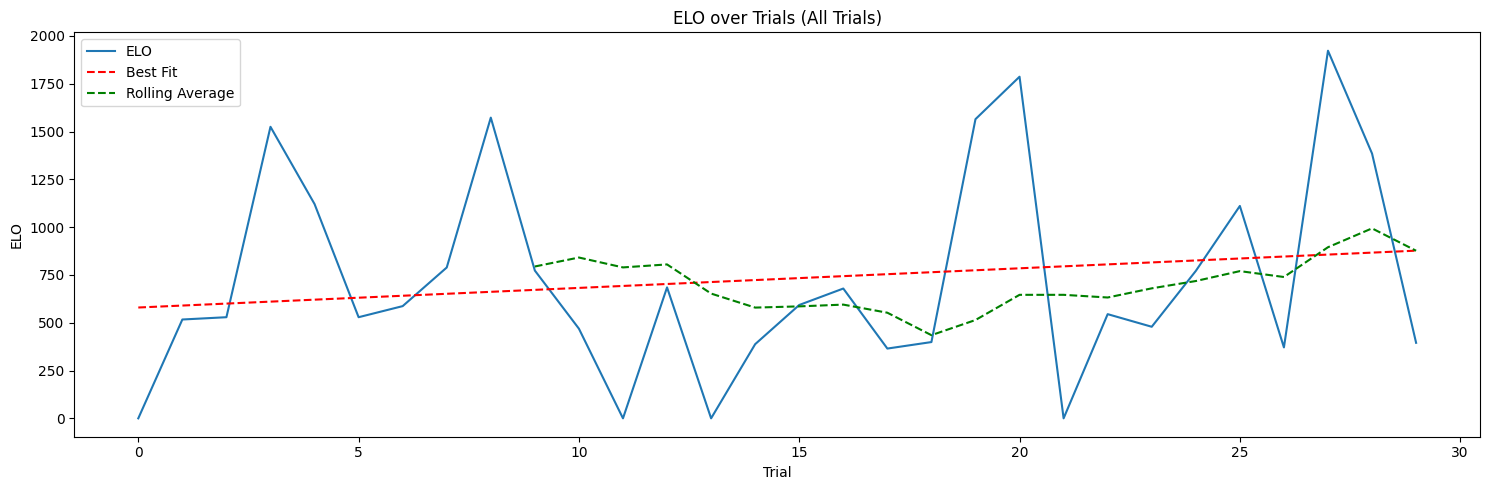

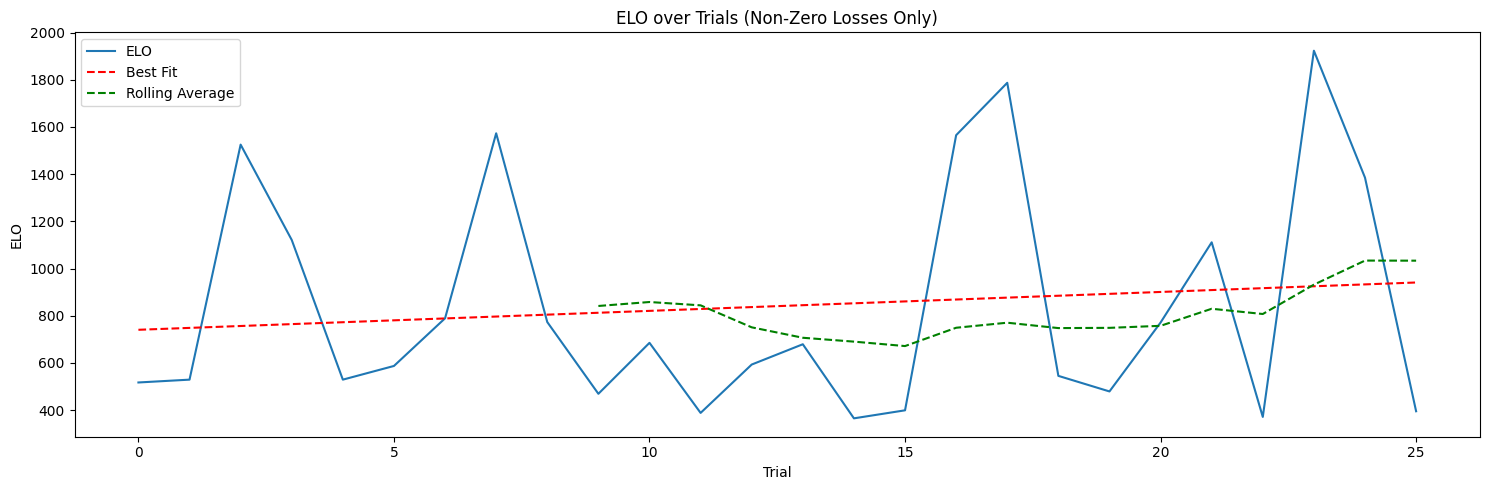

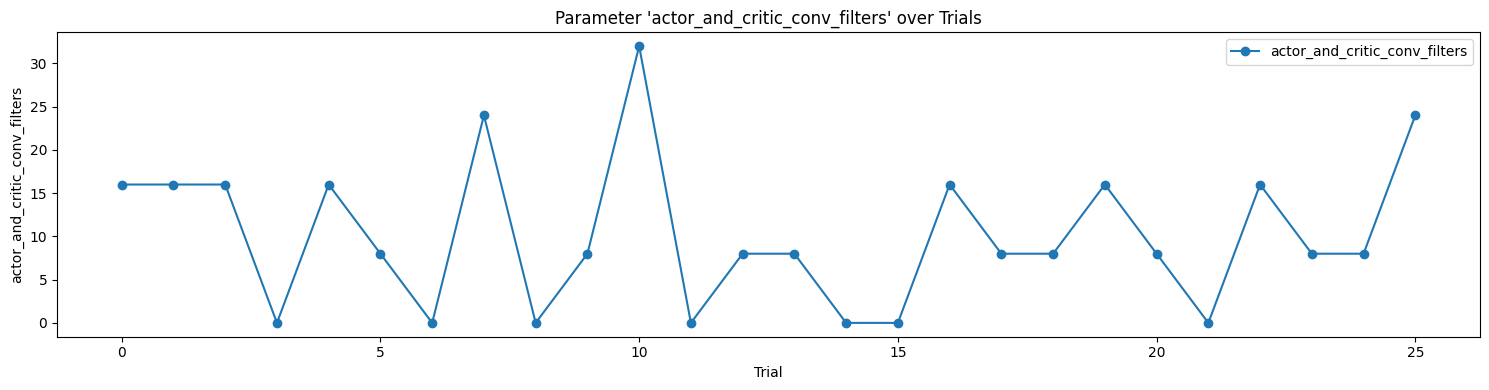

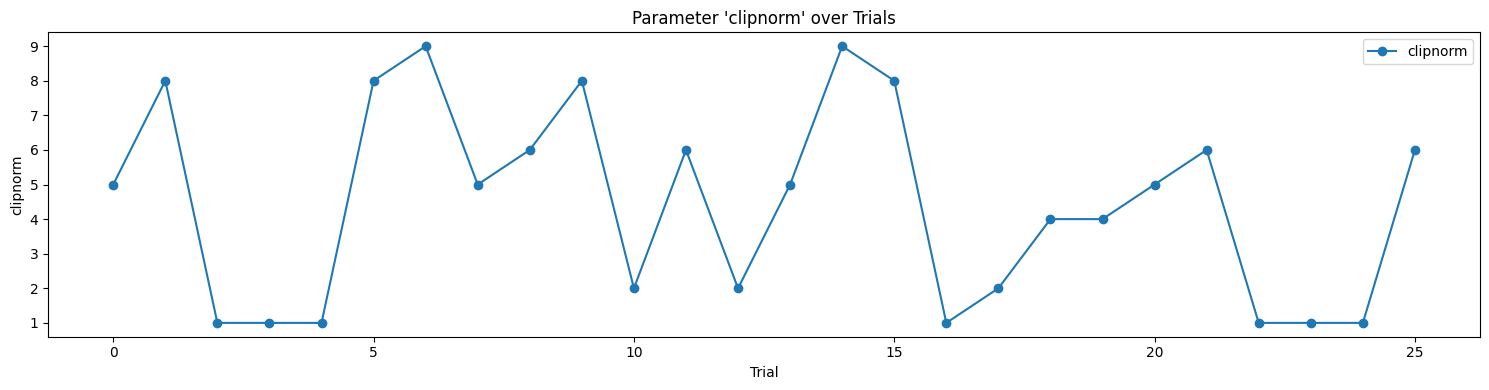

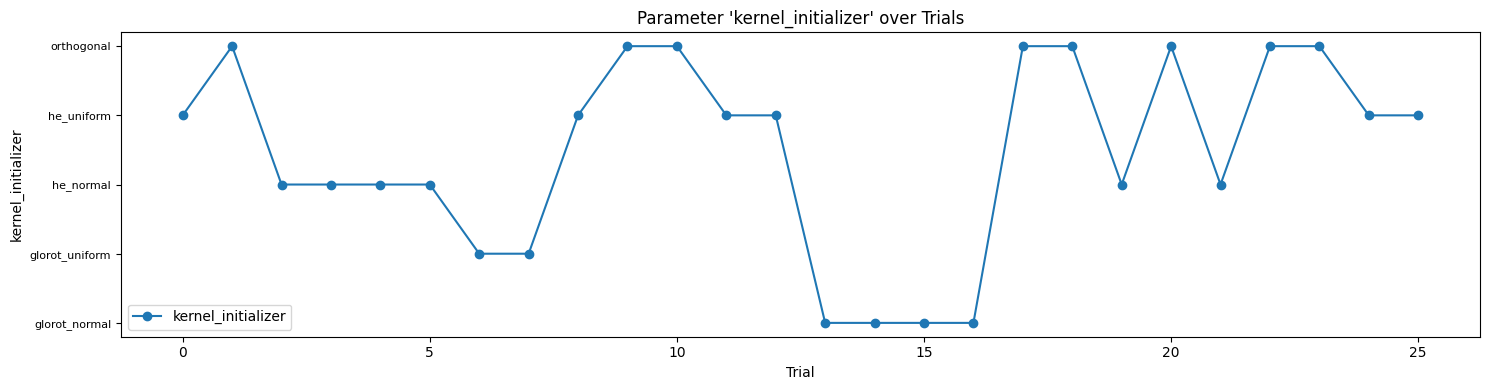

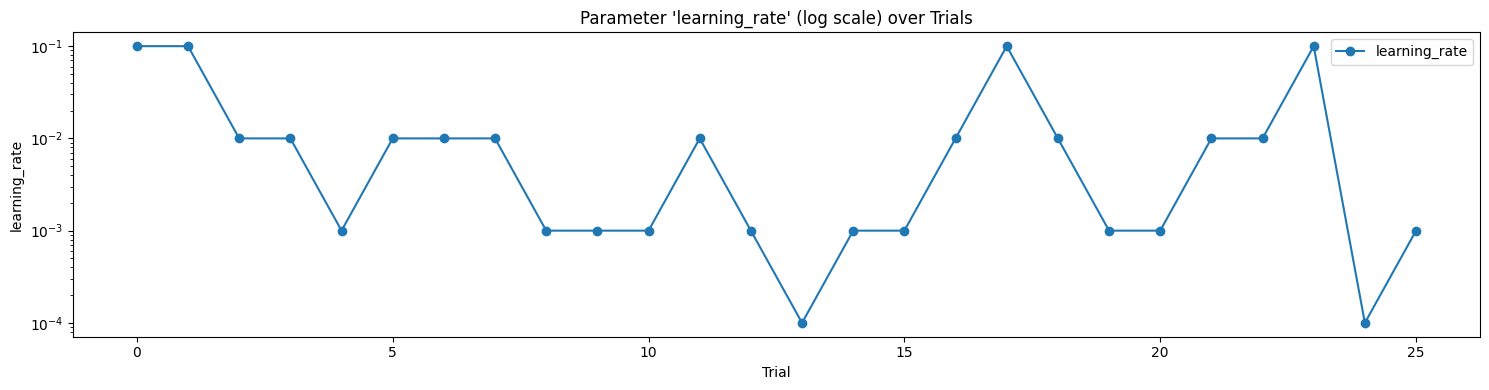

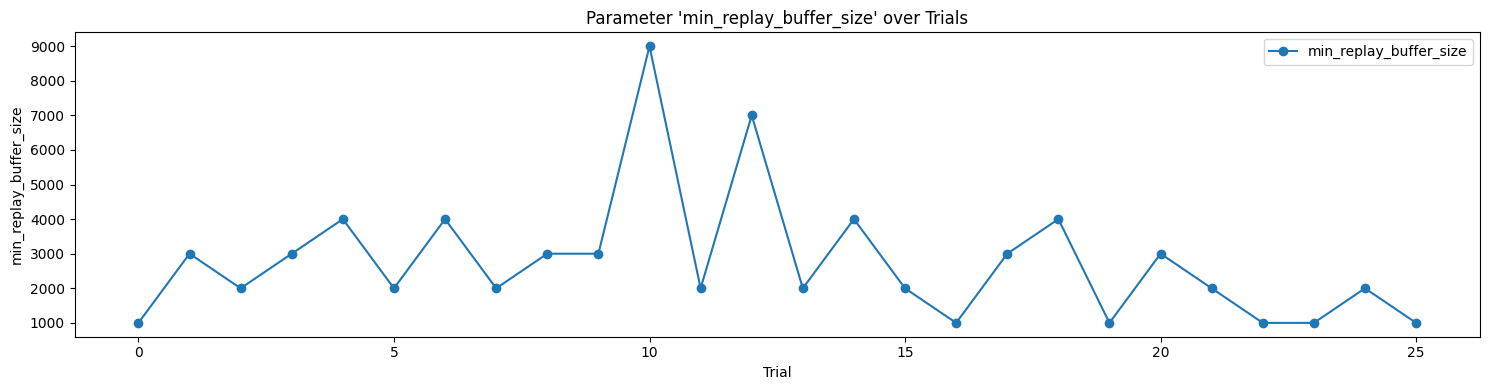

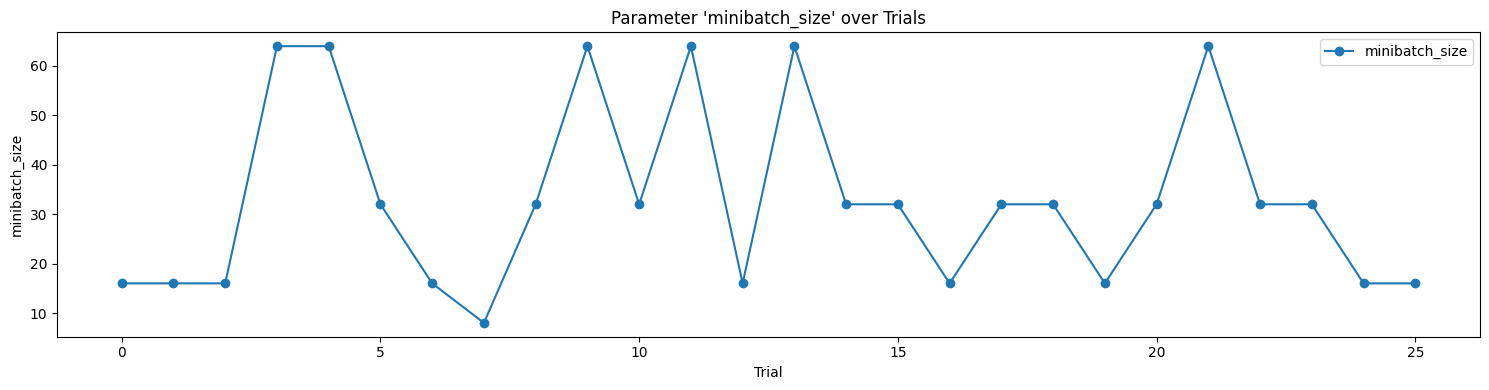

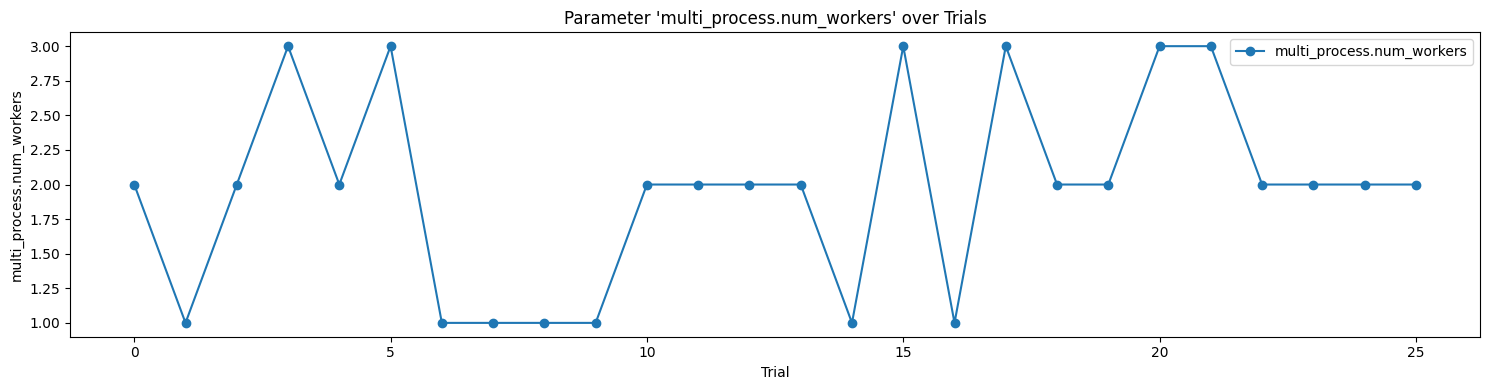

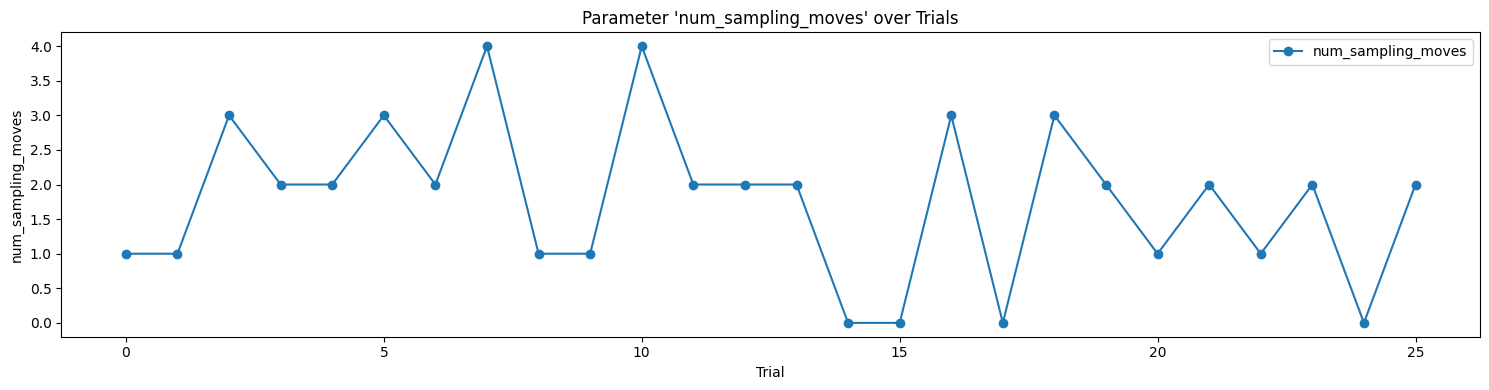

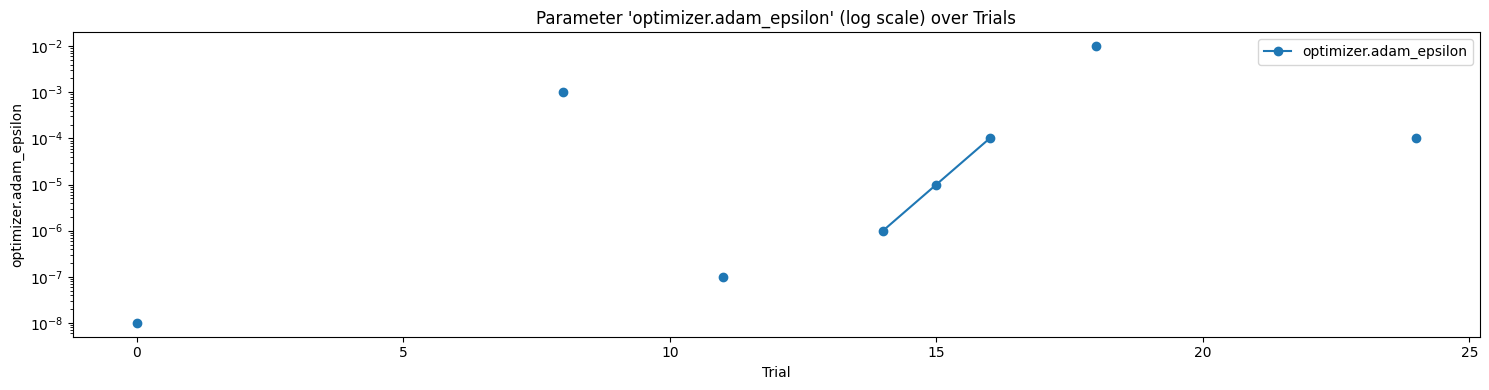

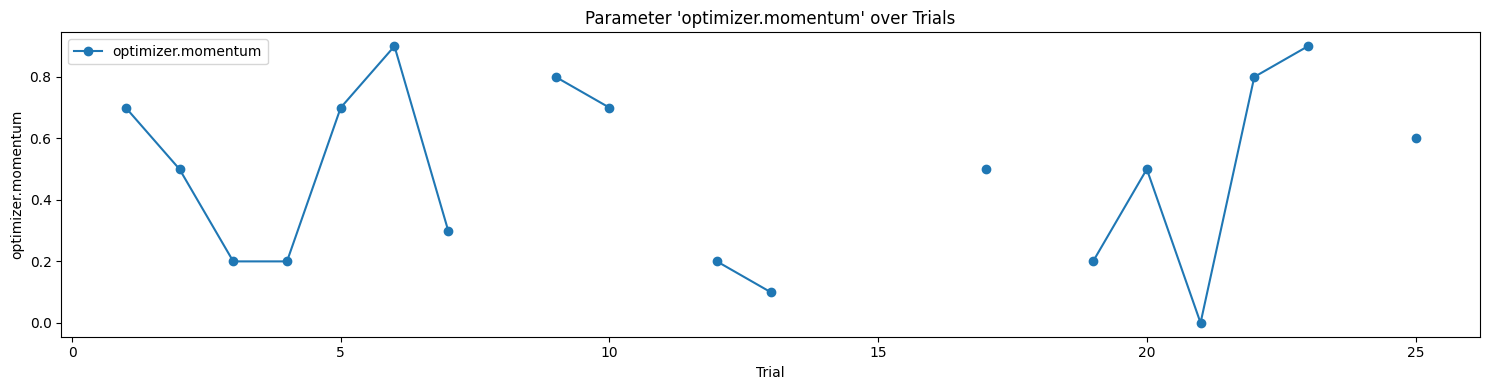

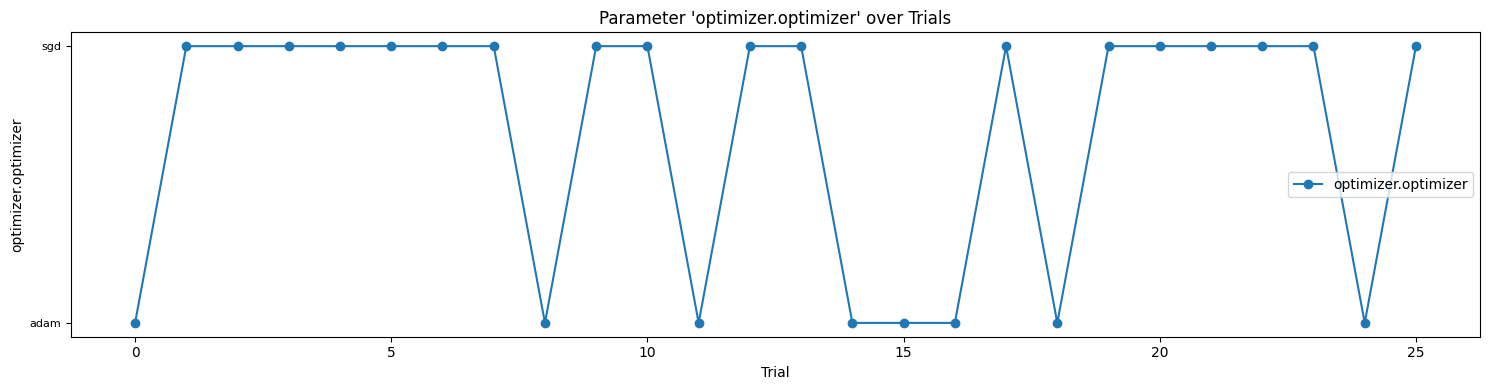

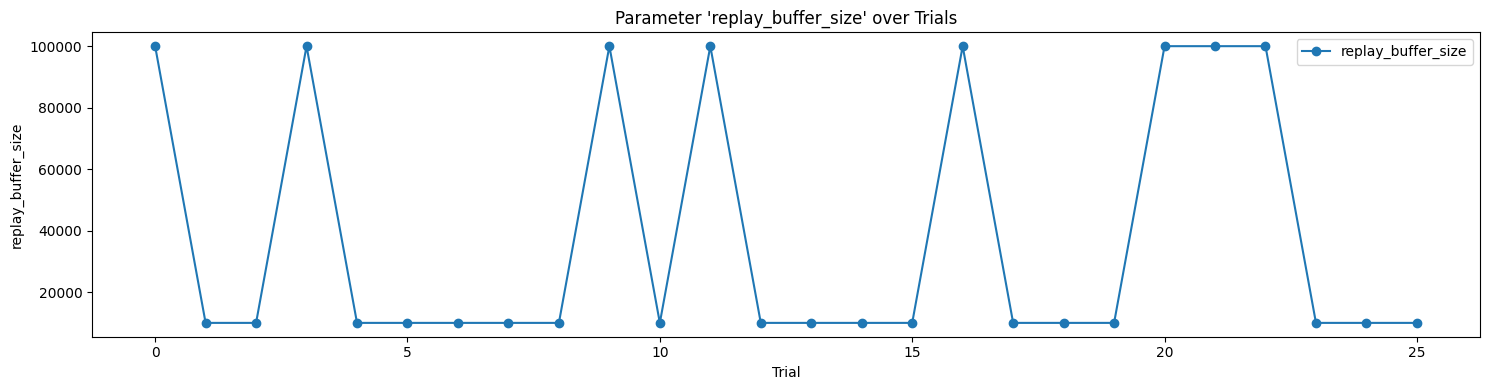

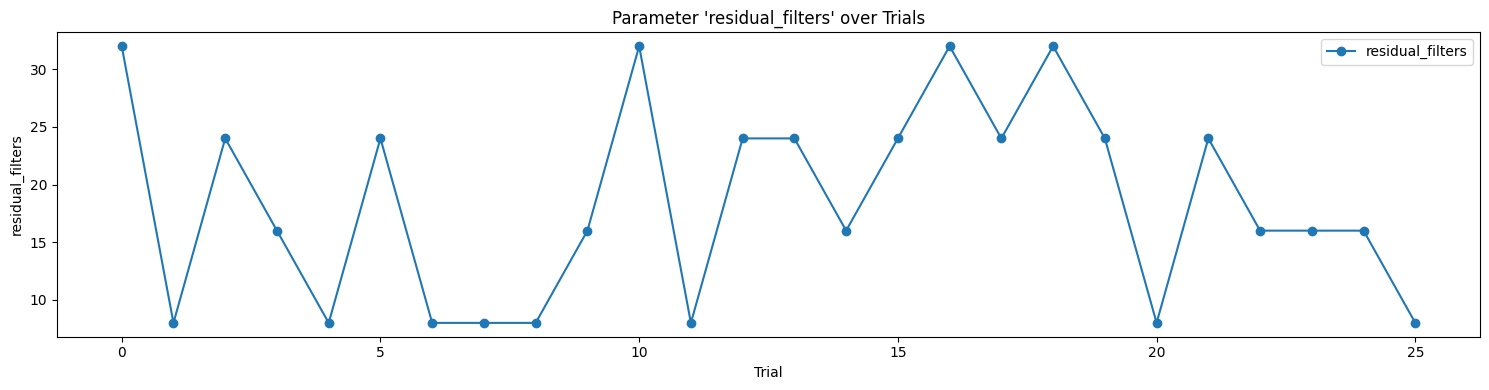

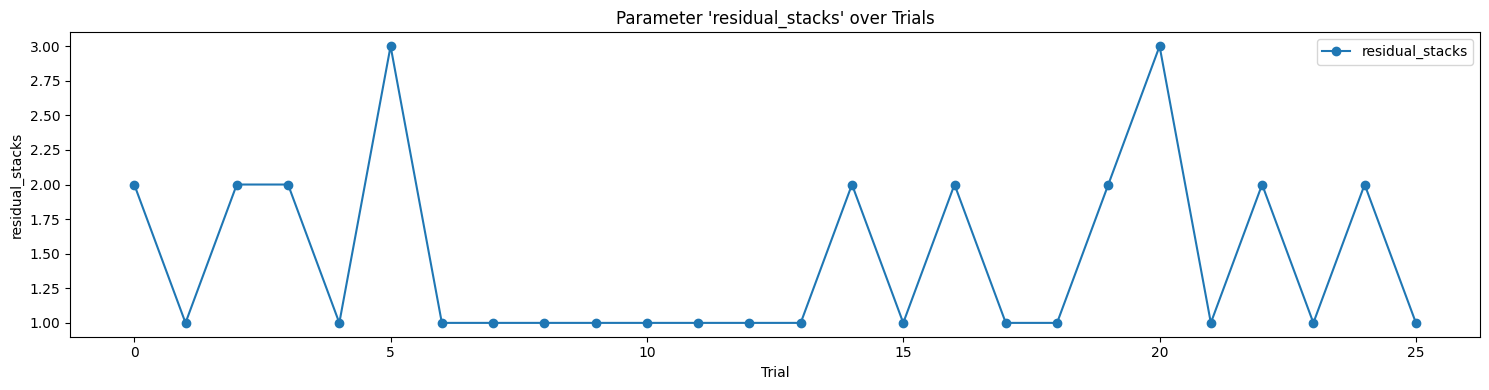

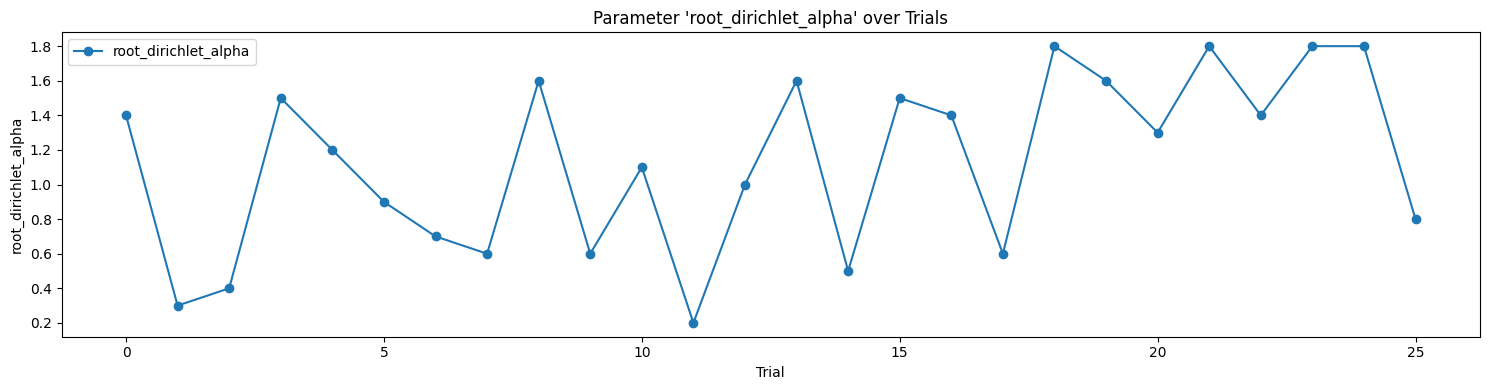

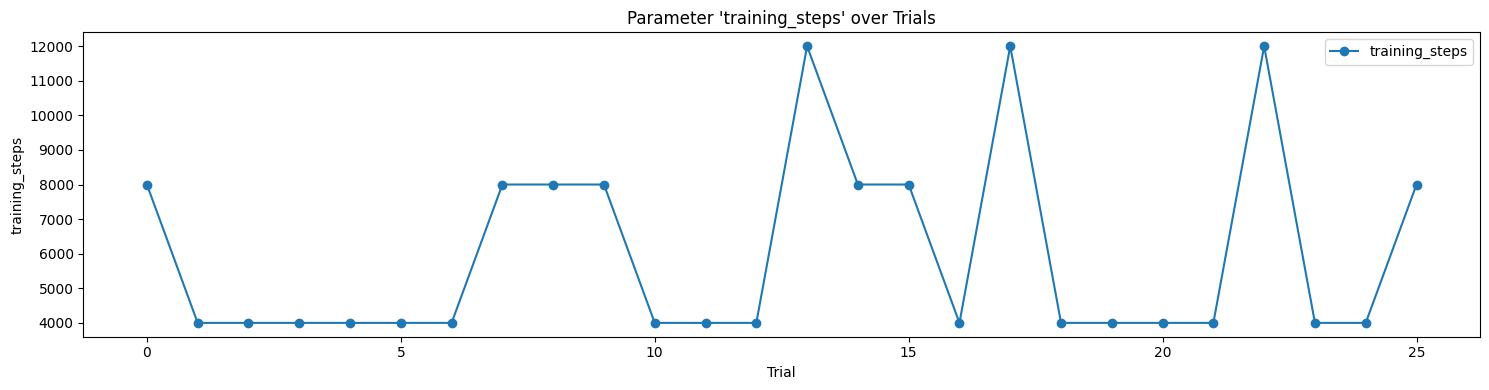

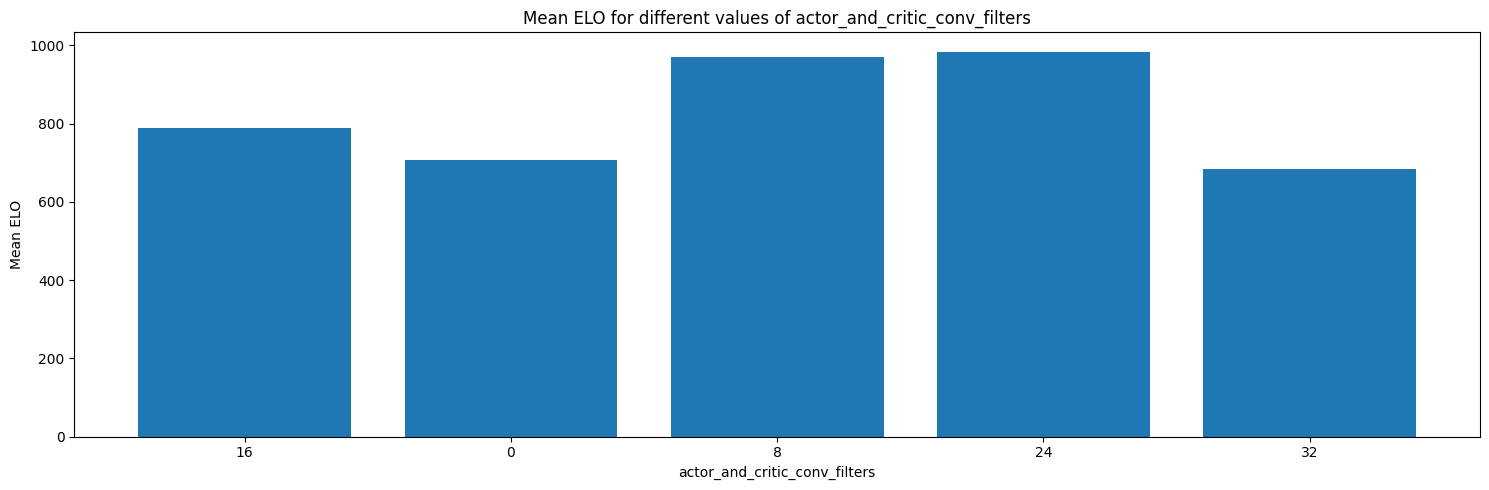

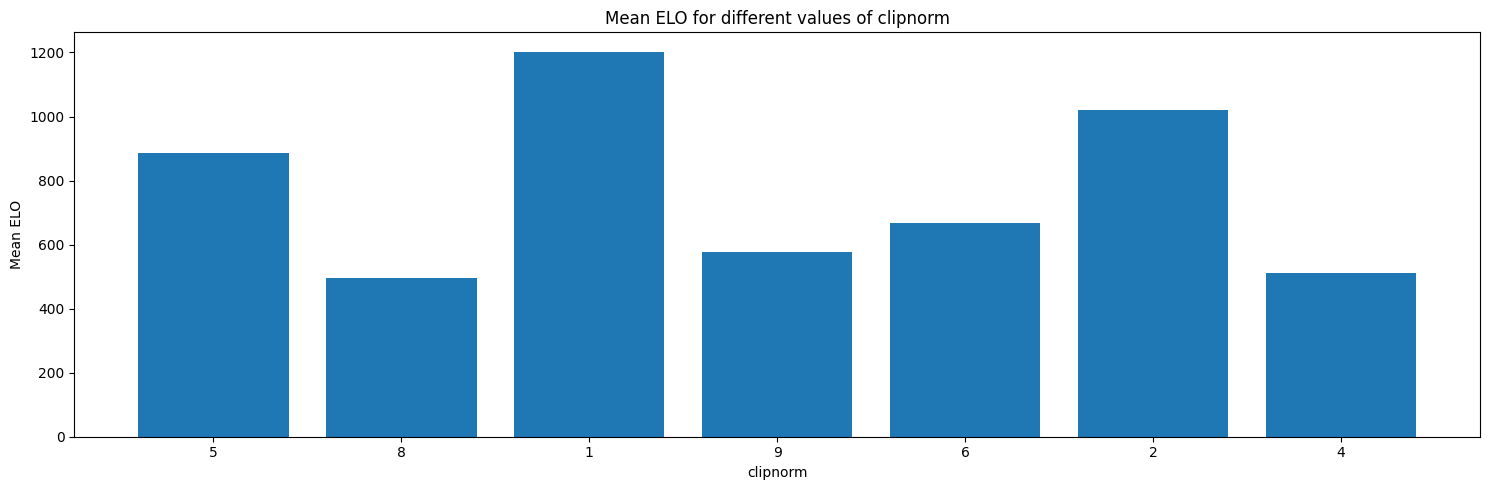

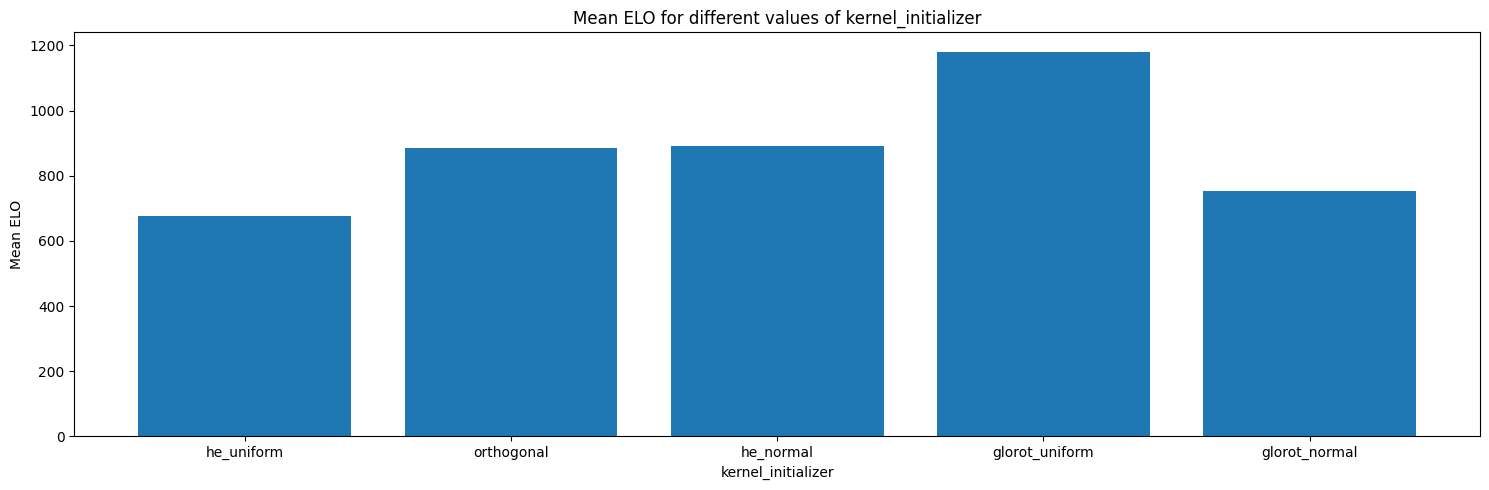

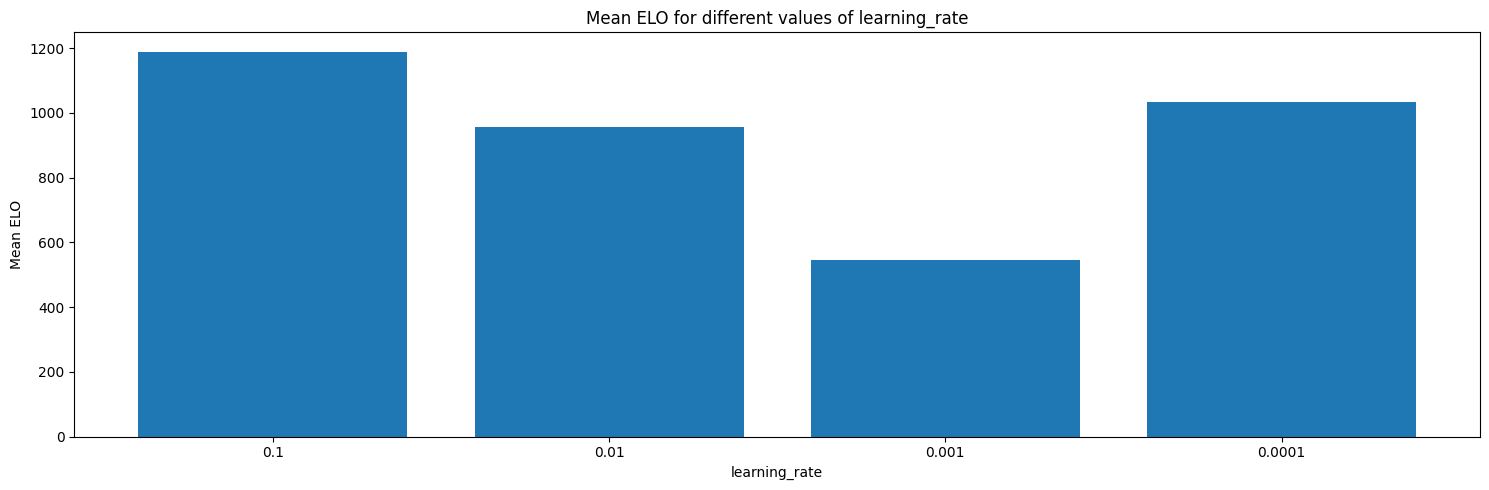

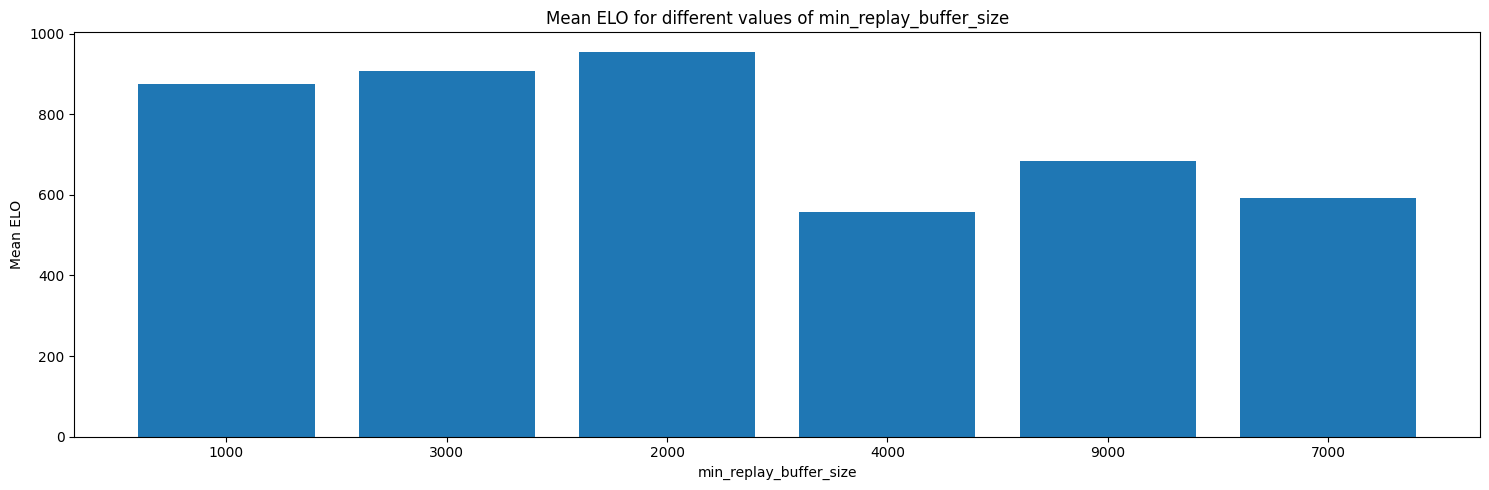

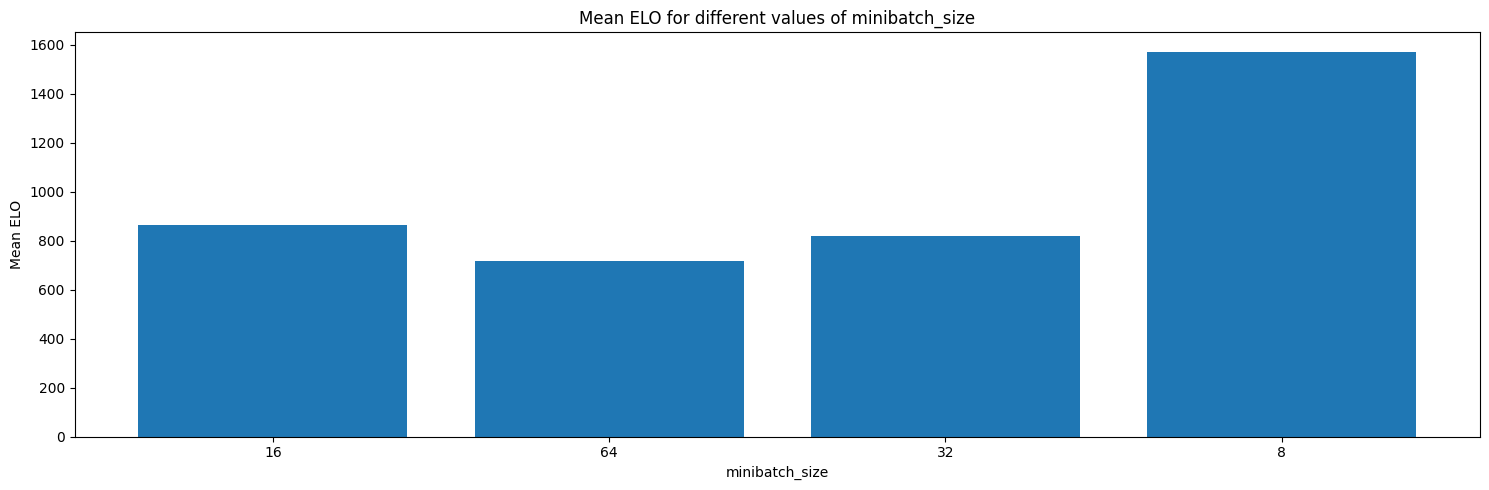

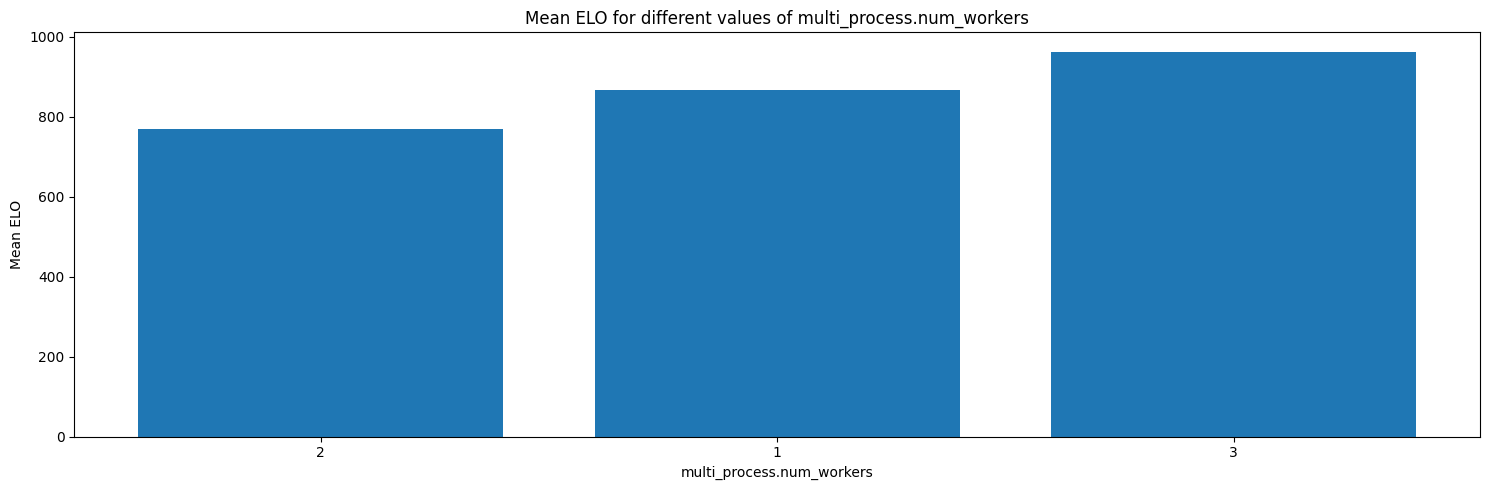

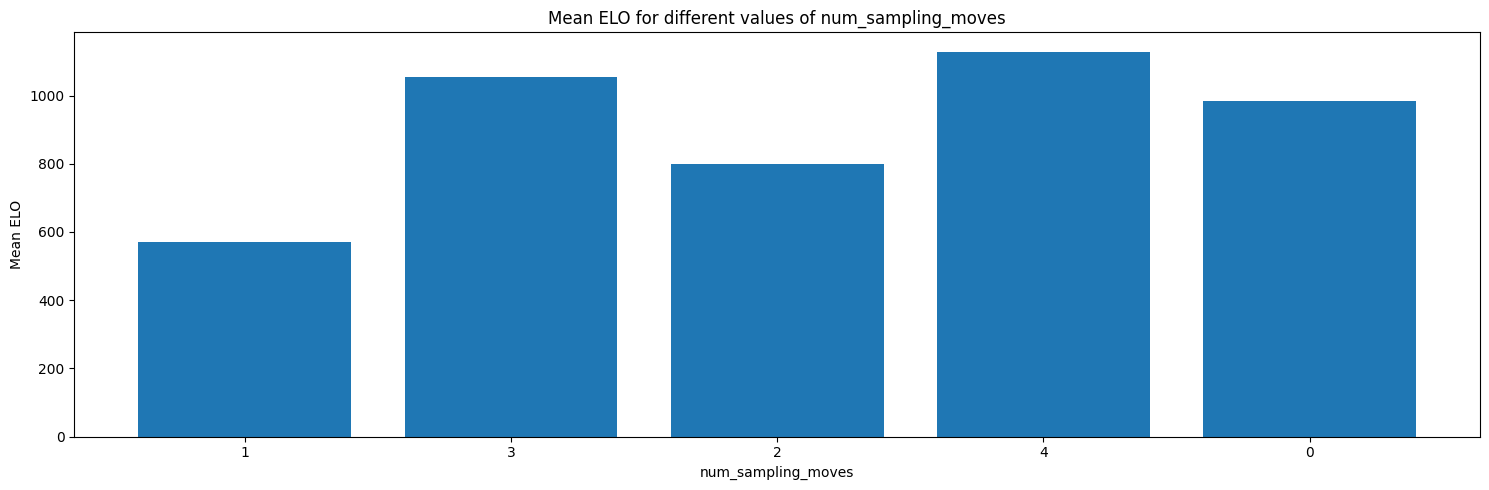

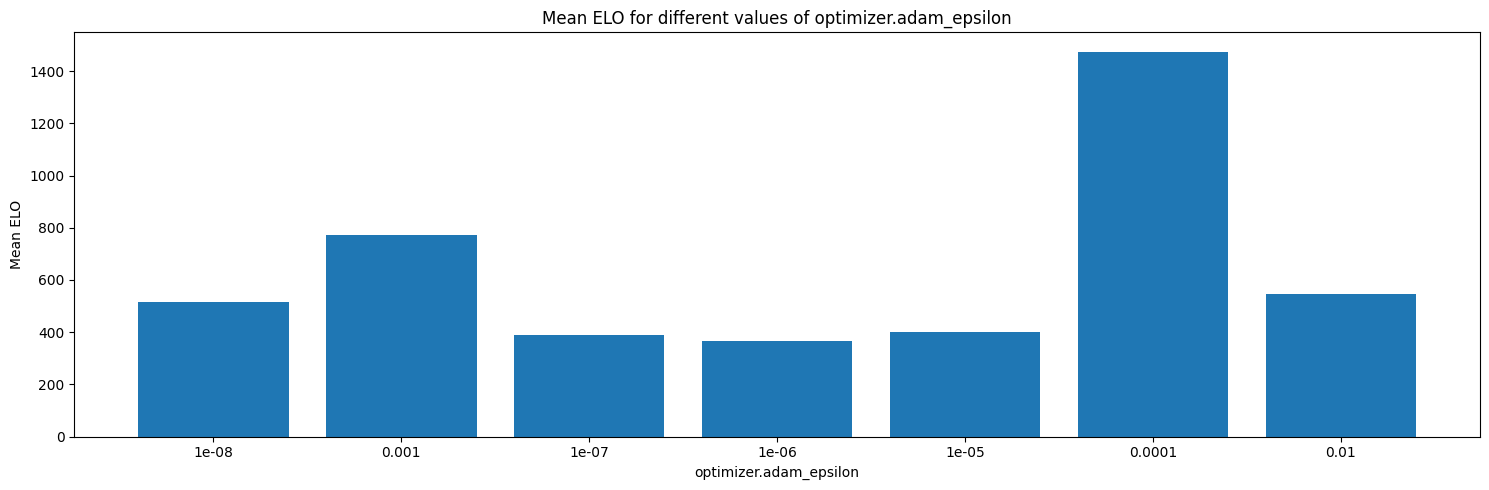

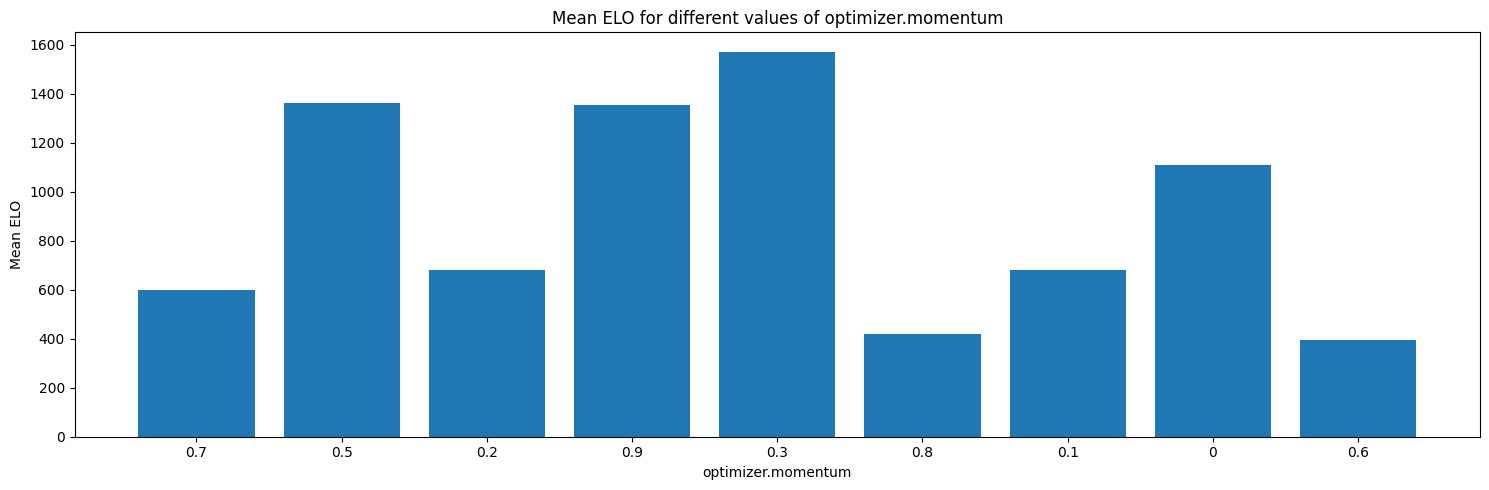

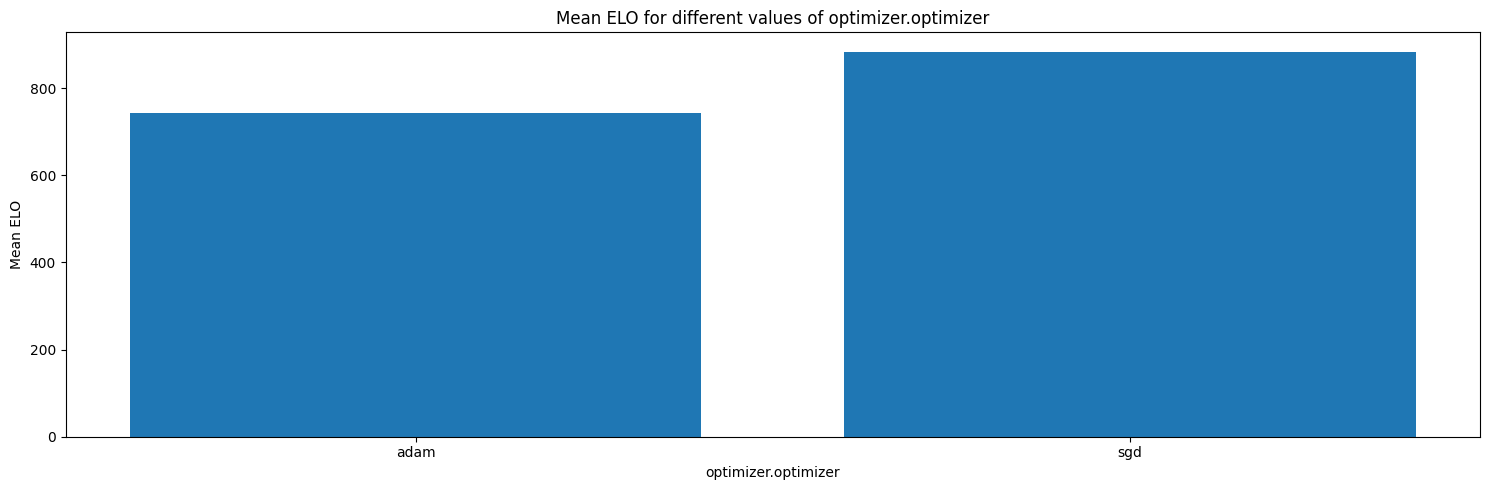

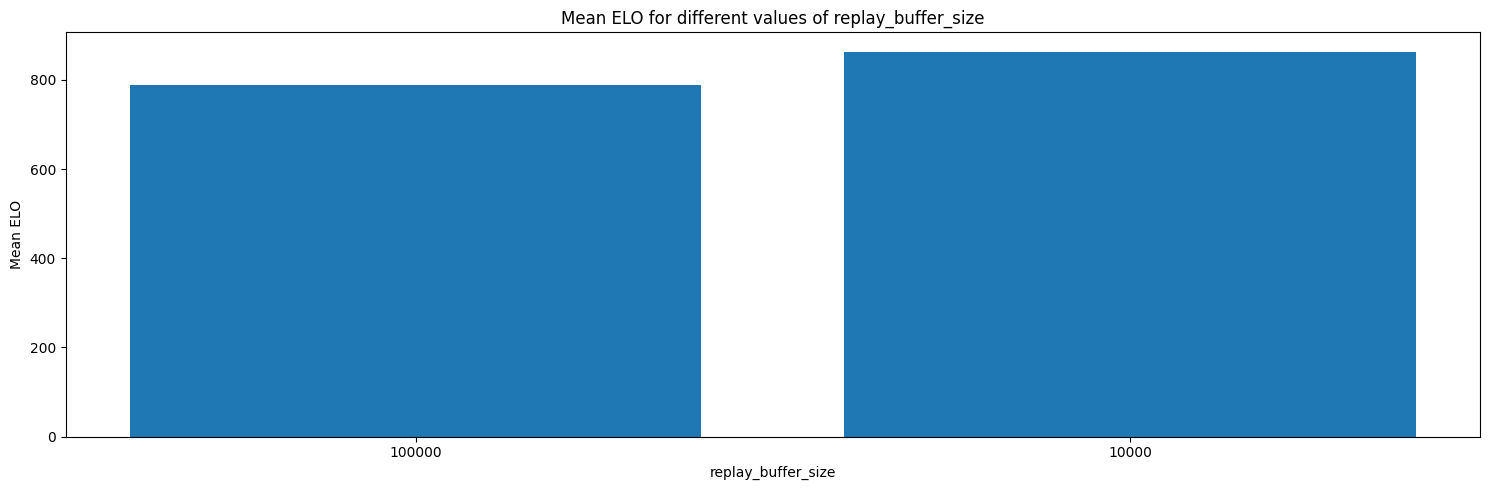

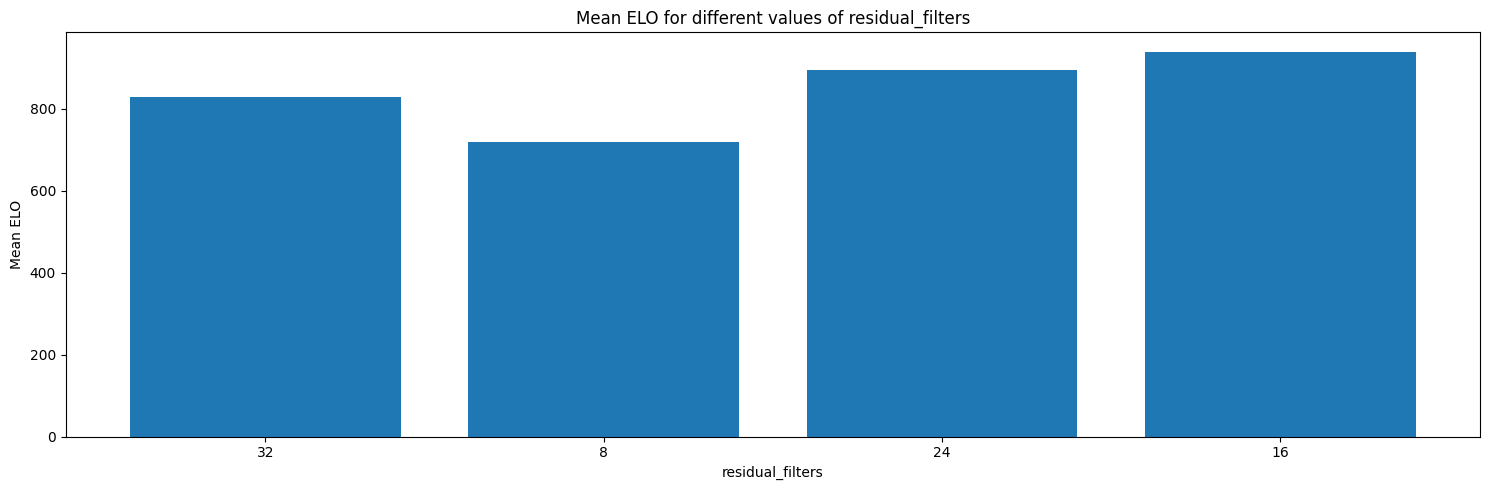

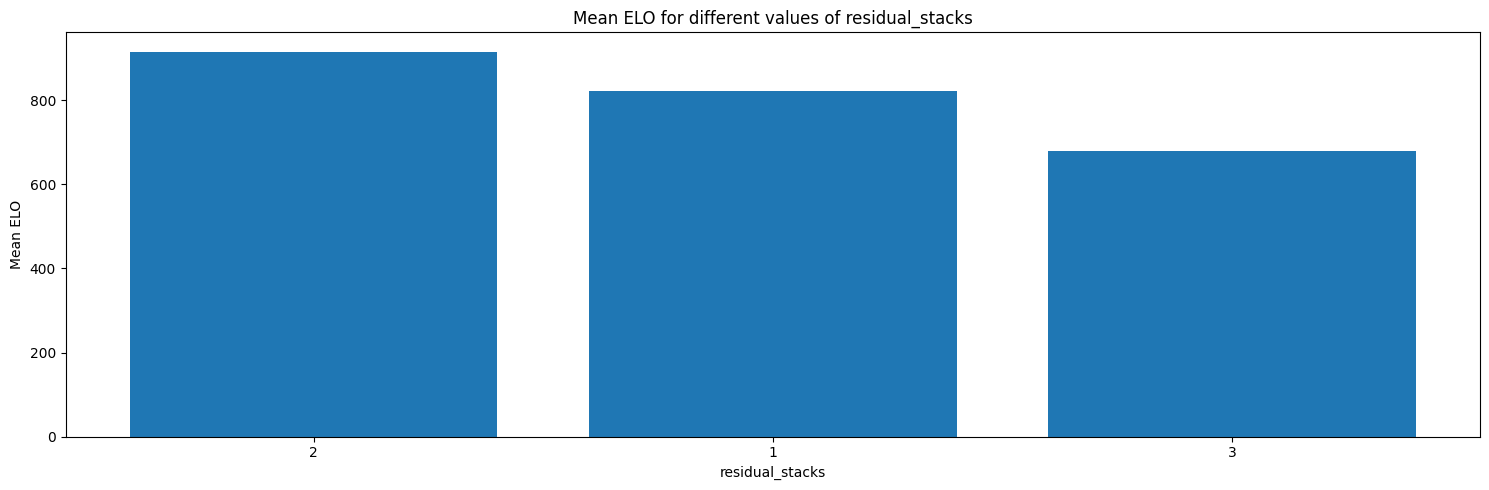

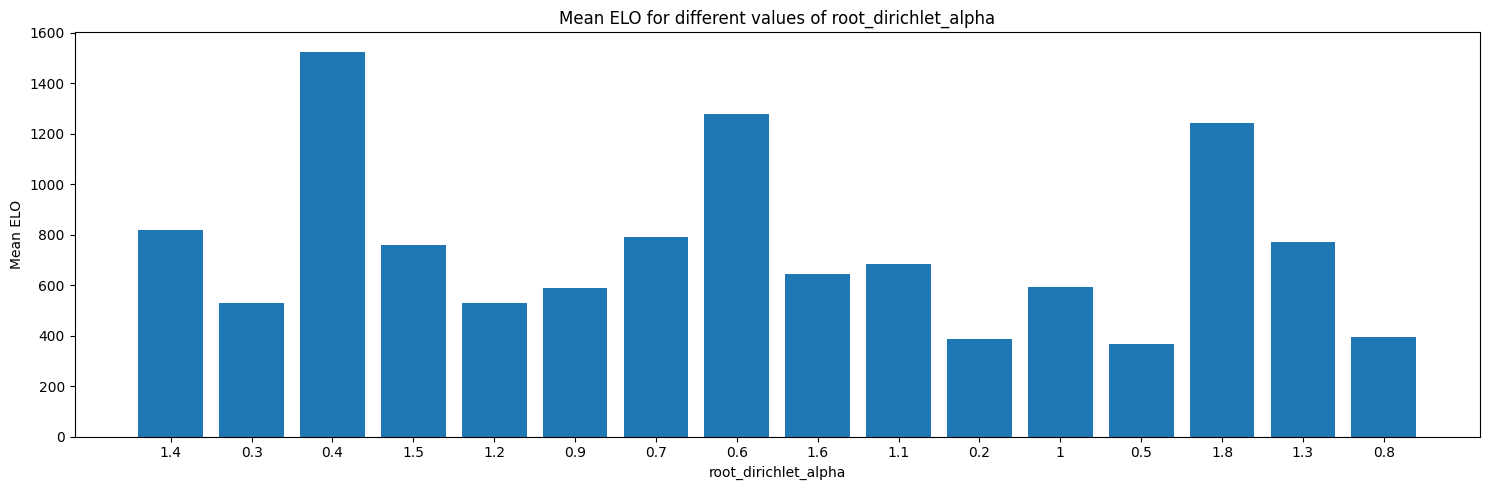

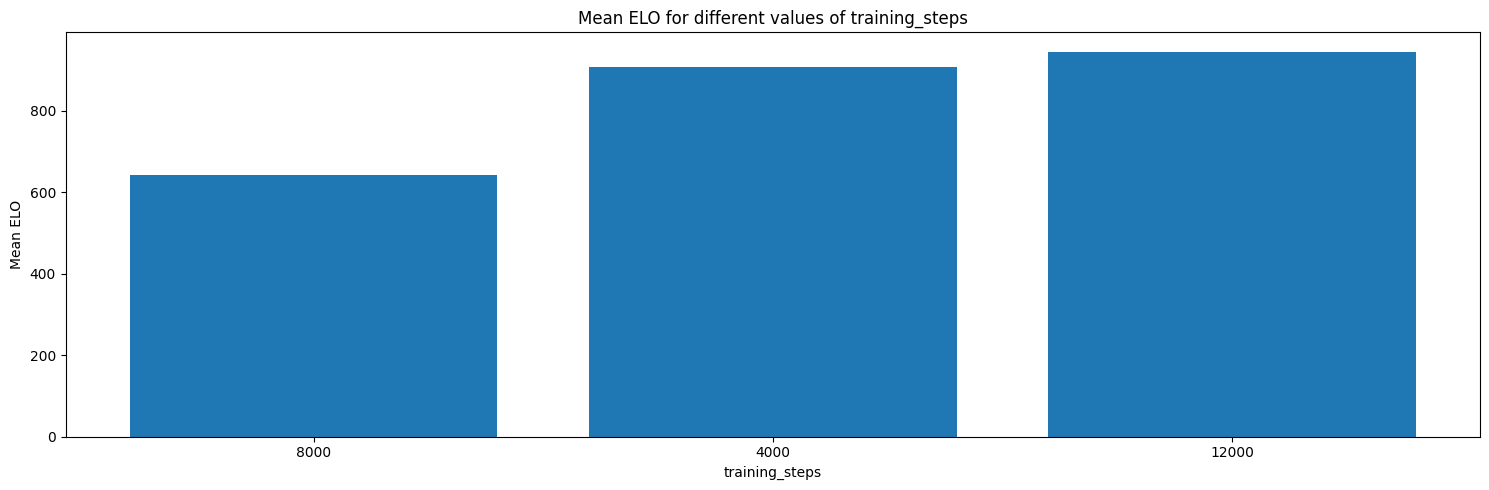

Max hyperparameter values:
actor_and_critic_conv_filters: 24
clipnorm: 1
kernel_initializer: glorot_uniform
learning_rate: 0.1
min_replay_buffer_size: 2000
minibatch_size: 8
multi_process.num_workers: 3
num_sampling_moves: 4
optimizer.adam_epsilon: 0.0001
optimizer.momentum: 0.30000000000000004
optimizer.optimizer: sgd
replay_buffer_size: 10000
residual_filters: 16
residual_stacks: 2
root_dirichlet_alpha: 0.4
training_steps: 12000


In [54]:
from hyperopt import space_eval
import dill as pickle
from matplotlib import pyplot as plt
import matplotlib
import numpy as np
import inspect

matplotlib.use('inline')
%matplotlib inline

# --- Collect parameters and losses ---
params = []
losses = []

for i, trial in enumerate(trials.trials):
    vals = {k: val[0] if len(val) > 0 else None for k, val in trial["misc"]["vals"].items()}
    param_dict = space_eval(search_space, vals)
    loss = -trial["result"]["loss"]
    losses.append(loss)
    params.append(param_dict)

# --- Plot initial ELO over trials ---
plt.figure(figsize=(15, 5))
plt.plot(range(len(losses)), losses, label="ELO")
z = np.polyfit(range(len(losses)), losses, 1)
p = np.poly1d(z)
plt.plot(range(len(losses)), p(range(len(losses))), "r--", label="Best Fit")
window_size = 10
rolling_avg = np.convolve(losses, np.ones(window_size)/window_size, mode='valid')
plt.plot(range(window_size - 1, len(losses)), rolling_avg, 'g--', label='Rolling Average')
plt.xlabel("Trial")
plt.ylabel("ELO")
plt.title("ELO over Trials (All Trials)")
plt.legend()
plt.tight_layout()
plt.show()

# --- Remove zero losses ---
filtered = [(l, p) for l, p in zip(losses, params) if l != 0]
if filtered:
    losses, params = zip(*filtered)
else:
    losses, params = [], []

# --- Replot ELO after filtering ---
if len(losses) > 0:
    plt.figure(figsize=(15, 5))
    plt.plot(range(len(losses)), losses, label="ELO")
    z = np.polyfit(range(len(losses)), losses, 1)
    p = np.poly1d(z)
    plt.plot(range(len(losses)), p(range(len(losses))), "r--", label="Best Fit")
    rolling_avg = np.convolve(losses, np.ones(window_size)/window_size, mode='valid')
    plt.plot(range(window_size - 1, len(losses)), rolling_avg, 'g--', label='Rolling Average')
    plt.xlabel("Trial")
    plt.ylabel("ELO")
    plt.title("ELO over Trials (Non-Zero Losses Only)")
    plt.legend()
    plt.tight_layout()
    plt.show()

# --- Helper: flatten nested dicts ---
def flatten_dict(d, parent_key='', sep='.'):
    items = []
    for k, v in d.items():
        new_key = f"{parent_key}{sep}{k}" if parent_key else k
        if isinstance(v, dict):
            items.extend(flatten_dict(v, new_key, sep=sep).items())
        else:
            items.append((new_key, v))
    return dict(items)

# --- Helper: make values safe for labels ---
def safe_value(v):
    """Converts any value (including classes/objects) into a safe, readable form."""
    try:
        if inspect.isclass(v):
            return v.__name__
        elif callable(v):
            return v.__name__ if hasattr(v, "__name__") else str(v)
        elif isinstance(v, (int, float, str, bool, type(None))):
            return v
        else:
            s = str(v)
            return s[:40] + "..." if len(s) > 40 else s
    except Exception:
        return str(type(v).__name__)

# --- Flatten and sanitize parameters ---
flat_params = [flatten_dict(p) for p in params]
for fp in flat_params:
    for k in list(fp.keys()):
        fp[k] = safe_value(fp[k])

# --- Collect all hyperparameter names ---
hyperparameters = sorted(set().union(*(p.keys() for p in flat_params)))

# --- Plot evolution of each parameter ---
for hyperparameter in hyperparameters:
    values = [p.get(hyperparameter, None) for p in flat_params]
    unique_vals = set(v for v in values if v is not None)
    if len(unique_vals) <= 1:
        continue

    plt.figure(figsize=(15, 4))

    if all(isinstance(v, (int, float)) for v in unique_vals):
        plt.plot(values, marker='o', label=hyperparameter)

        # Detect logarithmic values
        filtered = [x for x in values if x is not None]
        vmin, vmax = min(filtered), max(filtered)
        if vmin > 0 and vmax / vmin >= 1e3:  # 3+ orders of magnitude
            plt.yscale("log")
            plt.title(f"Parameter '{hyperparameter}' (log scale) over Trials")
        else:
            plt.title(f"Parameter '{hyperparameter}' over Trials")

    else:
        # Map categorical/object/string values to ints for plotting
        cat_to_int = {cat: i for i, cat in enumerate(sorted(map(str, unique_vals)))}
        mapped_vals = [cat_to_int.get(str(v), np.nan) for v in values]
        plt.plot(mapped_vals, marker='o', label=hyperparameter)
        plt.yticks(
            list(cat_to_int.values()),
            [str(k) for k in cat_to_int.keys()],
            fontsize=8
        )
        plt.title(f"Parameter '{hyperparameter}' over Trials")

    plt.xlabel("Trial")
    plt.ylabel(hyperparameter)
    plt.legend()
    plt.tight_layout()
    plt.show()

# --- Compute mean losses per parameter value ---
max_hyperparameter_value = {}

for hyperparameter in hyperparameters:
    values = [p.get(hyperparameter) for p in flat_params]
    valid = [(v, l) for v, l in zip(values, losses) if v is not None]
    if len(set(v for v, _ in valid)) <= 1:
        continue

    # Group losses by parameter value
    value_losses = {}
    for v, l in valid:
        value_losses.setdefault(v, []).append(l)

    mean_value_losses = {v: np.mean(ls) for v, ls in value_losses.items()}
    max_hyperparameter_value[hyperparameter] = max(mean_value_losses, key=mean_value_losses.get)

    # --- Plot mean ELO per value ---
    plt.figure(figsize=(15, 5))
    keys = list(mean_value_losses.keys())
    vals = [mean_value_losses[k] for k in keys]

    def fmt_label(x):
        if isinstance(x, float):
            return f"{x:.3g}"
        return str(x)[:30] + "..." if len(str(x)) > 30 else str(x)

    plt.bar(range(len(keys)), vals)
    plt.xticks(range(len(keys)), [fmt_label(k) for k in keys])
    plt.xlabel(hyperparameter)
    plt.ylabel("Mean ELO")
    plt.title(f"Mean ELO for different values of {hyperparameter}")
    plt.tight_layout()
    plt.show()

# --- Print best values ---
print("Max hyperparameter values:")
for hyperparameter, value in max_hyperparameter_value.items():
    print(f"{hyperparameter}: {value}")


In [7]:
# improve elo accuracy
play_1v1_tournament(players, games_per_pair, play_game)
print(table.bayes_elo()["Elo table"])

NameError: name 'play_1v1_tournament' is not defined

In [ ]:
print(table.bayes_elo()["Elo table"])

In [ ]:
# go from trial objects to params using the hyperparameter search space
from matplotlib import pyplot as plt
import matplotlib
matplotlib.use('inline')  # Set backend for Jupyter
%matplotlib inline

params = []
losses = []
elos = table.bayes_elo()["Elo table"]["Elo"]
print(elos)
for i, trial in enumerate(trials.trials):
    param = {}
    for key, value in trial["misc"]["vals"].items():
        if len(value) > 0:
            if key in search_space:
                # print(key, value)
                search_space_value = search_space[key]
                # print("key", key)
                # print("search_space_value", search_space_value)
                # print("value", value)
                # print("value[0]", value[0])
                if type(value[0]) == int:
                    param[key] = search_space_value.pos_args[value[0] + 1].eval()
                else:
                    param[key] = value[0]
    losses.append(elos[i] - 1000)
    params.append(param)

# plot losses over trials with best fit line
plt.figure()
plt.plot(range(len(losses)), losses)
# best fit line
import numpy as np
z = np.polyfit(range(len(losses)), losses, 1)
p = np.poly1d(z)
plt.plot(range(len(losses)), p(range(len(losses))), "r--")
plt.xlabel("Trial")
plt.ylabel("ELO")
plt.title("ELO over Trials")
plt.show()

# print(params[0])

hyperparameters = set()
for param in params:
    hyperparameters.update(param.keys())
# print(hyperparameters)

max_hyperparameter_value = {}
for hyperparameter in hyperparameters:
    values = set()
    for param in params:
        if hyperparameter in param:
            values.add(param[hyperparameter])
    print(f"{hyperparameter}: {values}")

    # get mean loss per value if more than one value
    if len(values) > 1:
        value_losses = {value: [] for value in values}
        for i, param in enumerate(params):
            if hyperparameter in param:
                value_losses[param[hyperparameter]].append(losses[i])
        mean_value_losses = {
            value: sum(value_losses[value]) / len(value_losses[value])
            for value in values
        }
        max_hyperparameter_value[hyperparameter] = max(mean_value_losses, key=mean_value_losses.get)
        num_values = {value: len(value_losses[value]) for value in values}
        #sort mean_value_losses by key
        mean_value_losses = dict(sorted(mean_value_losses.items()))

        print(f"Num values for {hyperparameter}: {num_values}")
        print(f"Mean losses for {hyperparameter}: {mean_value_losses}")

        # plot mean losses
        plt.figure()
        plt.bar(range(len(mean_value_losses.keys())), mean_value_losses.values())
        plt.xticks(range(len(mean_value_losses.keys())), mean_value_losses.keys())
        plt.xlabel(hyperparameter)
        plt.ylabel("Mean ELO")
        plt.title(f"Mean ELO for different values of {hyperparameter}")
        plt.show()

print("Max hyperparameter values:")
for hyperparameter, value in max_hyperparameter_value.items():
    print(f"{hyperparameter}: {value}")


In [ ]:
pickle.dump(table, open("updated_table.pkl", "wb"))